<a href="https://colab.research.google.com/github/ppulkit5/ShapeAi-Projects/blob/master/Earthquake_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Workflow 
- LANL Earthquake Prediction Kaggle Competition <a href="https://www.kaggle.com/c/LANL-Earthquake-Prediction/data">link</a>
- Step 1 - Installing dependencies
- Step 2 - Importing dataset
- Step 3 - Exploratory data analysis
- Step 4 - Feature engineering (statistical features added)
- Step 5 - Implement "Catboost" model
- Step 6 - Implement Support Vector Machine + Radial Basis Function model

# Step 1 - Install & Import Dependencies

In [1]:
#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy
#Machine learning
!pip install catboost

     |████████████████████████████████| 67.4 MB 27 kB/s 


In [2]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

# Step 2 - Import Dataset from Kaggle

Uploading the dataset directly from kaggle through kaggle.json file.
For this first go to kaggle site then go to your account there you can generate create new API token, upload the same below... 

In [3]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [4]:
#list of all competitions
!kaggle competitions list

ref                                                  deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                         2030-07-01 23:59:00  Getting Started     Prizes         62           False  
gan-getting-started                                  2030-07-01 23:59:00  Getting Started     Prizes        155           False  
tpu-getting-started                                  2030-06-03 23:59:00  Getting Started  Knowledge        218           False  
digit-recognizer                                     2030-01-01 00:00:00  Getting Started  Knowledge       1571           False  
titanic                                              2030-01-01 00:00:00  Getting Started  Knowledge      50371           False  
house-prices-advanced-regression-techniques          2030-01-01 00:00:00  Getting Started 

In [5]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/319k [00:00<?, ?B/s]
100% 319k/319k [00:00<00:00, 43.3MB/s]
  0% 0.00/320k [00:00<?, ?B/s]
100% 320k/320k [00:00<00:00, 105MB/s]
  0% 0.00/315k [00:00<?, ?B/s]
100% 315k/315k [00:00<00:00, 100MB/s]
  0% 0.00/324k [00:00<?, ?B/s]
100% 324k/324k [00:00<00:00, 106MB/s]
  0% 0.00/325k [00:00<?, ?B/s]
100% 325k/325k [00:00<00:00, 150MB/s]
  0% 0.00/329k [00:00<?, ?B/s]
100% 329k/329k [00:00<00:00, 101MB/s]
  0% 0.00/324k [00:00<?, ?B/s]
100% 324k/324k [00:00<00:00, 102MB/s]
  0% 0.00/360k [00:00<?, ?B/s]
100% 360k/360k [00:00<00:00, 118MB/s]
  0% 0.00/330k [00:00<?, ?B/s]
100% 330k/330k [00:00<00:00, 108MB/s]
  0% 0.00/329k [00:00<?, ?B/s]
100% 329k/329k [00:00<00:00, 105MB/s]
  0% 0.00/321k [00:00<?, ?B/s]
100% 321k/321k [00:00<00:00, 104MB/s]
  0% 0.00/332k [00:00<?, ?B/s]
100% 332k/332k [00:00<00:00, 101MB/s]
  0% 0.00/336k [00:00<?, ?B/s]
100% 336k/336k [00:00<00:00, 104MB/s]
  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 107MB/s]
  0% 0.00/319k [00:00<?, ?B/s]
10

In [6]:
#unzip training data for usage, will take about 5 minutes (its big)
!ls
!unzip train.csv.zip
!ls

sample_data	       seg_0042cc.csv  seg_006e4a.csv  seg_00e5f7.csv
sample_submission.csv  seg_004314.csv  seg_007a37.csv  seg_00f3b9.csv
seg_00030f.csv	       seg_004cd2.csv  seg_00a37e.csv  seg_010eab.csv
seg_0012b5.csv	       seg_004ee5.csv  seg_00be11.csv  seg_0125d9.csv
seg_00184e.csv	       seg_004f1f.csv  seg_00c35b.csv  train.csv.zip
seg_003339.csv	       seg_00648a.csv  seg_00cc91.csv
Archive:  train.csv.zip
  inflating: train.csv               
sample_data	       seg_0042cc.csv  seg_006e4a.csv  seg_00e5f7.csv
sample_submission.csv  seg_004314.csv  seg_007a37.csv  seg_00f3b9.csv
seg_00030f.csv	       seg_004cd2.csv  seg_00a37e.csv  seg_010eab.csv
seg_0012b5.csv	       seg_004ee5.csv  seg_00be11.csv  seg_0125d9.csv
seg_00184e.csv	       seg_004f1f.csv  seg_00c35b.csv  train.csv
seg_003339.csv	       seg_00648a.csv  seg_00cc91.csv  train.csv.zip


# Step 3 - Exploratory Data Analysis

In [7]:
#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [8]:
#print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


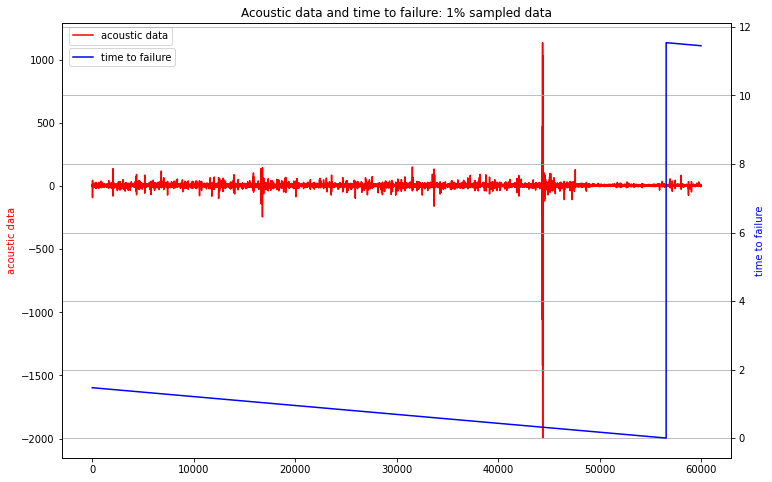

In [9]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

# Step 4 - Feature Engineering

In [10]:
# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)



In [11]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [12]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


# Step 5 - Implement Catboost Model

- Yandex is Russian Google
- Yandex uses "gradient boosting" a lot to power their services (music streaming, search, everything really)
- Gradient boosting on decision trees is a form of machine learning that works by progressively training more complex models to maximize the accuracy of predictions. 
- It's particularly useful for predictive models that analyze ordered (continuous) data and categorical data. 
- It's  one of the most efficient ways to build ensemble models. The combination of gradient boosting with decision trees provides state-of-the-art results in many applications with structured data.
- On the first iteration, the algorithm learns the first tree to reduce the training error, shown on left-hand image in figure 1. 
- This model usually has a significant error; it’s not a good idea to build very big trees in boosting since they overfit the data.
- The right-hand image in figure 1 shows the second iteration, in which the algorithm learns one more tree to reduce the error made by the first tree. 
- The algorithm repeats this procedure until it builds a decent quality model

![alt text](https://devblogs.nvidia.com/wp-content/uploads/2018/12/first-second-trees-625x357.png)


- Gradient Boosting is a way to implement this idea for any continuous objective function. 

### Each step of Gradient Boosting combines two steps:

- Step 1 - Computing gradients of the loss function we want to optimize for each input object
- Step 2 - Learning the decision tree which predicts gradients of the loss function

### ELI5 Time

- Step 1 - We first model data with simple models and analyze data for errors. 
- Step 2 - These errors signify data points that are difficult to fit by a simple model. 
- Step 3 - Then for later models, we particularly focus on those hard to fit data to get them right. 
- Step 4 -  In the end, we combine all the predictors by giving some weights to each predictor.


In [13]:
#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.3776750114110539}}

# Step 6 - Implement Support Vector Machine + Radial Basis Function Kernel 


- A very simple and intuitive way of thinking about kernels (at least for SVMs) is a similarity function. 
- Given two objects, the kernel outputs some similarity score. The objects can be anything starting from two integers, two real valued vectors, trees whatever provided that the kernel function knows how to compare them.

- The arguably simplest example is the linear kernel, also called dot-product. Given two vectors, the similarity is the length of the projection of one vector on another.

- Another interesting kernel examples is Gaussian kernel. Given two vectors, the similarity will diminish with the radius of σ. The distance between two objects is "reweighted" by this radius parameter.

- The success of learning with kernels (again, at least for SVMs), very strongly depends on the choice of kernel. You can see a kernel as a compact representation of the knowledge about your classification problem. It is very often problem specific.


In [14]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}
